In [1]:
import numpy as np
import pandas as pd
import cortico_cereb_connectivity.run_model as rm
import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as at
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.evaluation as ev
import matplotlib.pyplot as plt
import SUITPy as suit

In [2]:
def plot_cereb_data(data,cereb_atlas,cscale=[-0.1,0.1]):
    # Transform the data to a nifti image
    nifti_img = cereb_atlas.data_to_nifti(data)
    # Map to the cerebellar flatmap 
    flat_data = suit.flatmap.vol_to_surf(nifti_img)
    # Plot 
    suit.flatmap.plot(flat_data,new_figure=False,cscale=cscale)

In [3]:
dataset_name = 'Somatotopic'
method = 'L2reghalf'
config = rm.get_eval_config(eval_dataset=dataset_name, eval_ses='all', model='ind', cerebellum='MNISymC3', add_rest=True)
dataset = fdata.get_dataset_class(gl.base_dir, dataset=dataset_name)
config["subj_list"] = dataset.get_participants().participant_id
cereb_atlas,_ = at.get_atlas('MNISymC3')

In [4]:
# Load Y of Somatotopic to check reliability
Y_relieability = []
for i, sub in enumerate(config["subj_list"]):
    print(f'- Load {sub}')

    YY, info, _ = fdata.get_dataset(gl.base_dir,
                                config["eval_dataset"],
                                atlas=config["cerebellum"],
                                sess=config["eval_ses"],
                                type=config["type"],
                                subj=str(sub))

    # Remove Nans
    Y = np.nan_to_num(YY[0,:,:])

    # Add explicit rest to sessions
    if config["add_rest"]:
        Y,info = rm.add_rest(Y,info)

    #Definitely subtract intercept across all conditions
    Y = (Y - Y.mean(axis=0))

    if 'std_cerebellum' in config.keys():
        Y = rm.std_data(Y,config['std_cerebellum'])

    _, R_vox, _, _ = ev.calculate_reliability(Y, info)
    Y_relieability.append(R_vox)

- Load sub-01
- Load sub-02
- Load sub-03
- Load sub-04
- Load sub-05
- Load sub-06
- Load sub-07
- Load sub-08


In [11]:
# Load L2reghalf models of Somatotopic parcel to check reliability
la = 8
dirname = f"L2reghalf_parcel/{dataset_name}_all_Icosahedron1002_{method}"
mname = f"{dataset_name}_all_Icosahedron1002_{method}_A{la}"

W_parcel_reliability = []
fm, _ = rm.get_fitted_models([dirname], [mname], config)
fm = fm[0]

for i, conn_model in enumerate(fm):
    _, R_vox = ev.calculate_R(conn_model.coef_1.T, conn_model.coef_2.T)
    W_parcel_reliability.append(R_vox)

In [6]:
# Load L2reghalf models of Somatotopic global to check reliability
la = 8
dirname = f"{dataset_name}_all_Icosahedron1002_{method}"
mname = f"{dataset_name}_all_Icosahedron1002_{method}_A{la}"

W_global_reliability = []
fm, _ = rm.get_fitted_models([dirname], [mname], config)
fm = fm[0]

for i, conn_model in enumerate(fm):
    _, R_vox = ev.calculate_R(conn_model.coef_1.T, conn_model.coef_2.T)
    W_global_reliability.append(R_vox)

In [18]:
reliability_df = pd.DataFrame(columns=['subj_id', 'Parcel', 'Global', 'Y'])
reliability_df['subj_id'] = config["subj_list"]
reliability_df['Parcel'] = W_parcel_reliability
reliability_df['Global'] = W_global_reliability
reliability_df['Y'] = Y_relieability

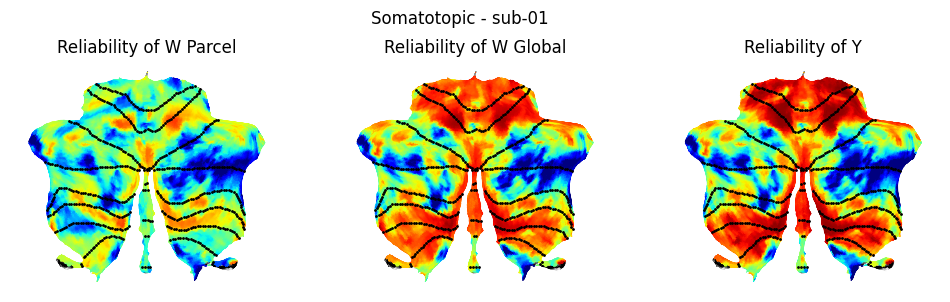

<Figure size 640x480 with 0 Axes>

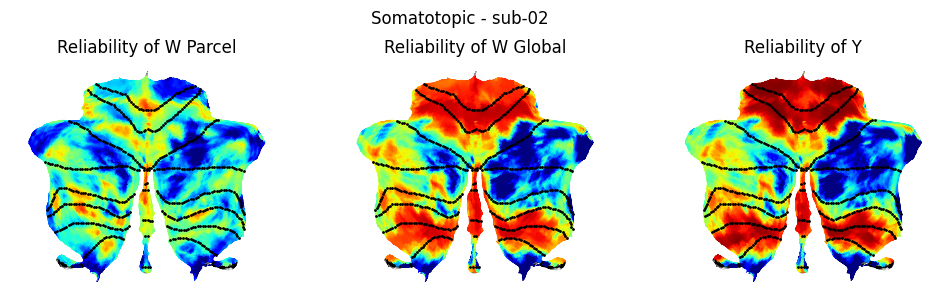

<Figure size 640x480 with 0 Axes>

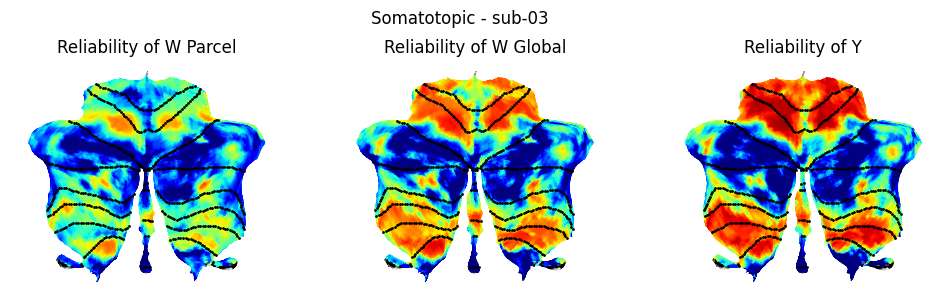

<Figure size 640x480 with 0 Axes>

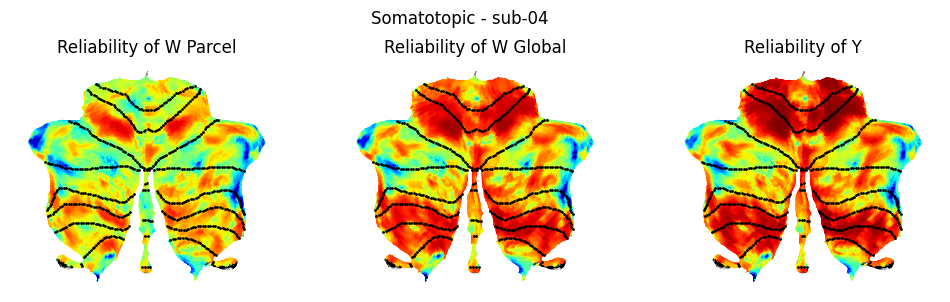

<Figure size 640x480 with 0 Axes>

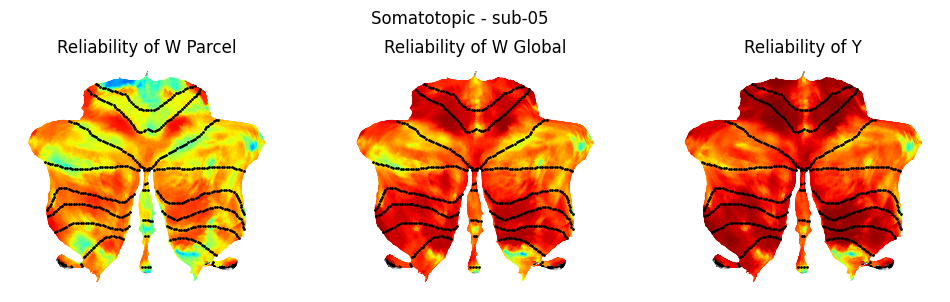

<Figure size 640x480 with 0 Axes>

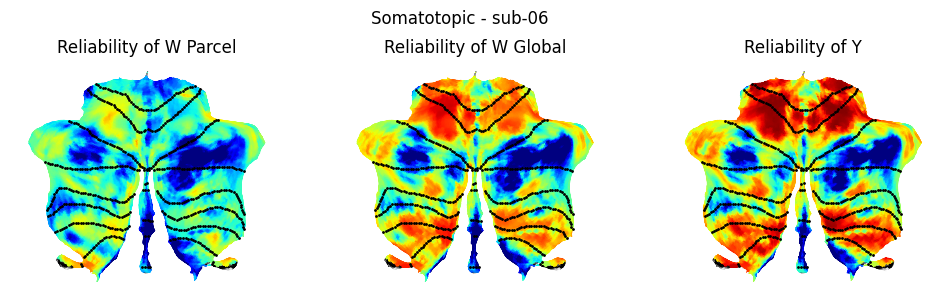

<Figure size 640x480 with 0 Axes>

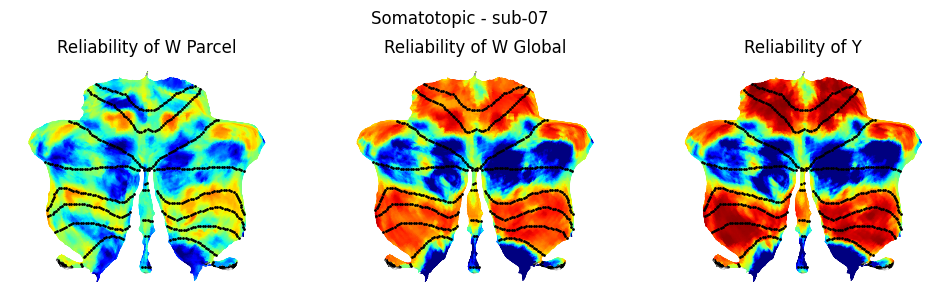

<Figure size 640x480 with 0 Axes>

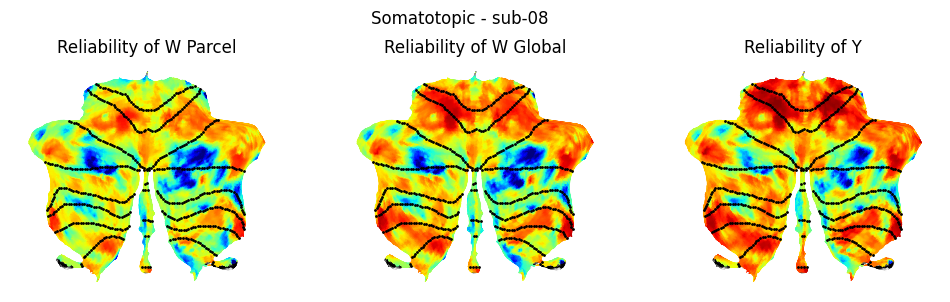

<Figure size 640x480 with 0 Axes>

In [22]:
for idx in range(len(reliability_df)):
    plt.subplots(1, 3, figsize=(12, 3))
    plt.suptitle(f"{dataset_name} - {reliability_df.loc[idx, 'subj_id']}", y=1.05)

    plt.subplot(1, 3, 1)
    plot_cereb_data(reliability_df.loc[idx, 'Parcel'], cereb_atlas, cscale=[0, 1])
    plt.title(f"Reliability of W Parcel")

    plt.subplot(1, 3, 2)
    plot_cereb_data(reliability_df.loc[idx, 'Global'], cereb_atlas, cscale=[0, 1])
    plt.title(f"Reliability of W Global")

    plt.subplot(1, 3, 3)
    plot_cereb_data(reliability_df.loc[idx, 'Y'], cereb_atlas, cscale=[0, 1])
    plt.title(f"Reliability of Y")
    plt.show()
    plt.tight_layout()